In [2]:
import os
import glob
import time
import psutil
import serial
import numpy as np
import datetime
from pylsl import StreamInfo, StreamOutlet, resolve_streams
from dareplane_utils.general.time import sleep_s
import logging

from typing import List

logger = logging.getLogger(__name__)


In [ ]:

class StimController:
    def __init__(self, port: str):
        self.port = port
        self.baud_rate = 115200
        
        # self.optimize_timer_resolution()
        
        self.codebooks = []
        self.n_objs = 8
        
        # Connect to teensy
        self.teensy = None
        self.connect_teensy()
        
        # Start marker stream
        self.sequence_outlet = None
        self.init_sequence_lsl_stream()
        # Start marker stream
        self.marker_outlet = None
        self.init_marker_lsl_stream()
        
        # Start description stream
        self.desc_outlet = None
        self.init_desc_lsl_stream()
        
        # Experimental setup for codebooks 1 and 2
        self.sequence_on_duration = 0.1
        self.sequence_off_duration = 0.15
        self.sequence_duration = self.sequence_on_duration + self.sequence_off_duration
        self.trial_duration = 12
        self.trial_rest_duration = 3
        self.n_trials = self.n_objs
        
        self.run_duration = self.trial_duration * self.n_trials + self.trial_rest_duration * (self.n_trials - 1)
        self.run_rest_duration = 30
        self.n_runs = 3
        
        # Exeriment vars
        self.trial_num = 1
        self.run_num = 1
        self.block_num = 1
    
    def connect_teensy(self) -> None:
        try:
            self.teensy = serial.Serial(self.port, self.baud_rate, timeout=1)
            sleep_s(2)  # Wait for Arduino to initialize
        except Exception as e:
            logging.warning(f"Teensy not connected: {e}")
    
    def init_sequence_lsl_stream(self) -> None:
        """cf_int8 = 6, cf_string = 3
        """
        info = StreamInfo(name='SequenceStream', type='Marker', channel_count=8, channel_format=6)
        self.sequence_outlet = StreamOutlet(info)
    
    def init_marker_lsl_stream(self) -> None:
        info = StreamInfo(name='MarkerStream', type='Marker', channel_count=1, channel_format=3)
        self.marker_outlet = StreamOutlet(info)
        
    def init_desc_lsl_stream(self) -> None:
        info = StreamInfo(name='DescriptionStream', type='Marker', channel_count=1, channel_format=3)
        self.desc_outlet = StreamOutlet(info)
    
    def optimize_timer_resolution(self) -> None:
        """Optimize the timer resolution to improve precision."""
        import ctypes
        try:
            logging.info("Optimizing timer resolution...")
            ctypes.windll.winmm.timeBeginPeriod(1)
            logging.info("Timer resolution set to 1ms.")
        except Exception as e:
            logging.warning(f"Error optimizing timer resolution: {e}")
        
        p = psutil.Process(os.getpid())
        p.nice(psutil.HIGH_PRIORITY_CLASS if os.name == 'nt' else 10)
        logging.info("Priority set. Running script...")
    
    def send_laser_values(self, values) -> None:
        if self.teensy is not None:
            data_str = ",".join(map(str, values)) + "\n"
            self.teensy.write(data_str.encode())  # Send data
    
    def load_codebook(self, filepath: str) -> np.ndarray:
        codebook = np.load(filepath).T
        assert codebook.shape[1] == self.n_objs, f'Codebook shape should be (n_sequences, {self.n_objs}). Current shape: {codebook.shape}'
        return codebook

    def load_codebooks_block_1(self, filepath: str='./codebooks/condition_1/codebook_1_henrich.npy') -> None:
        """Block 1 aka Henrich's codebook"""
        self.codebooks = []
        codebook = self.load_codebook(filepath)
        for _ in range(self.n_objs):
            self.codebooks.append(codebook.tolist())
        logging.info(f'Codebooks loaded. shape: {np.array(self.codebooks).shape}')
            
    def load_codebooks_block_2(self, dir: str='./codebooks/condition_2') -> None:
        """Block 2 aka custom codebook"""
        self.codebooks = []
        
        fpaths = sorted(glob.glob(f'{dir}/codebook_obj_*.npy'))
        assert len(fpaths) == self.n_objs, f'there should be {self.n_objs} codebooks for block 2. Current codebooks: {len(fpaths)}'
        
        for fpath in fpaths:
            codebook = self.load_codebook(fpath).tolist()
            self.codebooks.append(codebook)
        logging.info(f'Codebooks loaded. shape: {np.array(self.codebooks).shape}')
        
    def load_codebooks_block_3(self, fpath: str='./codebooks/condition_3/mseq_61_shift_8.npy') -> None:
        """Block 2 aka custom cVEP"""
        self.codebooks = []
        
        codebook = self.load_codebook(fpath)
        # Select 8 codebooks
        codebook = np.vstack([codebook] * self.trial_duration)
        self.codebooks = np.array([codebook] * 8)
        self.codebooks = self.codebooks.tolist()
        
        logging.info(f'Codebooks loaded. shape: {np.array(self.codebooks).shape}')
            
    def post_sequence(self, sequence: list):
        """send sequence to lsl stream"""
        try:
            sequence = [int(i) for i in sequence]
            self.sequence_outlet.push_sample(sequence)
        except Exception as e:
            logging.warning(f"Error posting sequence: {e}")
            
    def post_description(self, description: str):
        """send description to lsl stream"""
        try:
            self.desc_outlet.push_sample([description])
        except Exception as e:
            logging.warning(f"Error posting description: {e}")
            
    def post_marker(self, marker: str):
        """send marker to lsl stream"""
        try:
            self.marker_outlet.push_sample([marker])
        except Exception as e:
            logging.warning(f"Error posting marker: {e}")

    def run_sequence(self, sequence: list):
        """Run a single sequence"""
        # Turn on the Lasers
        end_time = datetime.datetime.now() + datetime.timedelta(seconds=self.sequence_on_duration)
        self.send_laser_values(sequence)
        self.post_sequence(sequence)
        # Wait until turn on duration is over
        while datetime.datetime.now() < end_time:
            pass
        
        # Turn off the lasers
        if self.sequence_off_duration != 0:
            end_time = datetime.datetime.now() + datetime.timedelta(seconds=self.sequence_off_duration)
            self.send_laser_values([0] * 8)
            self.post_sequence([0] * 8)
            # Wait until turn off duration is over
            while datetime.datetime.now() < end_time:
                pass
        
    def run_trial(self, codebook: list):
        """Run a single trial with multiple sequences"""
        self.post_description(f'Block:{self.block_num} Run:{self.run_num} Trial:{self.trial_num}')
        self.post_marker('Trial start')
        for sequence in codebook:
            sequence_start_time = datetime.datetime.now()
            self.run_sequence(sequence)
            dt = datetime.datetime.now() - sequence_start_time
            logging.info(f'Sequence duration: {dt.seconds // 60} mins {dt.seconds % 60} secs {dt.microseconds / 1000} ms')
        self.post_marker('Trial end')
        self.trial_num = self.trial_num + 1
            
    def run_run(self):
        """Run a single run with multiple trials"""
        self.post_marker('Run start')

        obj_order = np.random.permutation(np.arange(self.n_objs))
        codebooks = self.codebooks[obj_order]
                
        for codebook in codebooks:
            trial_start_time = datetime.datetime.now()
            self.run_trial(codebook)
            dt = datetime.datetime.now() - trial_start_time
            logging.info(f'Trial duration: {dt.seconds // 60} mins {dt.seconds % 60} secs {dt.microseconds / 1000} ms')
            # Rest for trial_rest_duration seconds
            rest_end_time = datetime.datetime.now() + datetime.timedelta(seconds=self.trial_rest_duration)
            self.post_description('Rest')
            self.post_marker('Trial Rest')
            self.send_laser_values([0] * 8)
            self.post_sequence([0] * 8)
            while datetime.datetime.now() < rest_end_time:
                pass
        self.post_marker('Run end')
        self.trial_num = 1
        self.run_num = self.run_num + 1
                
    def run_block(self):
        """Run a block with multiple runs"""
        self.post_marker('Block start')
        for _ in range(self.n_runs):
            self.post_marker('Run Rest')
            for i in range(30):
                self.post_description(f'Rest. Run start in: {30 - i}')
                sleep_s(1)
                
            run_start_time = datetime.datetime.now()
            self.run_run()
            dt = datetime.datetime.now() - run_start_time
            logging.info(f'Run duration: {dt.seconds // 60} mins {dt.seconds % 60} secs {dt.microseconds / 1000} ms')
        self.post_marker('Block end')
        self.run_num = 1
        self.block_num = self.block_num + 1
        
    def run_session(self):
        # Start ERP condition 1
        self.load_codebooks_block_1()
        self.run_block()
        
        # Start ERP condition 2
        self.load_codebooks_block_2()
        self.run_block()
        
        # Start cVEP
        self.load_codebooks_block_3()
        self.sequence_on_duration = 1/63
        self.sequence_off_duration = 0
        self.run_block()
        
    def run_test(self):
        """Run a test sequence"""
        self.post_description('Test sequence')
        self.post_marker('Test start')
        for i in range(8):
            self.run_sequence([0] * 8)
            self.run_sequence([1] * 8)
        self.post_marker('Test end')
        self.post_description('Test end')

In [4]:
port = 'COM5'  # Windows
port = '/dev/tty.usbmodem156466901' # Mac
controller = StimController(port)

Generated source_id: '6862202147842022927' for StreamInfo with name 'SequenceStream', type 'Marker', channel_count 8, nominal_srate 0.0, and channel_format 6.
Generated source_id: '-6825640803886660845' for StreamInfo with name 'MarkerStream', type 'Marker', channel_count 1, nominal_srate 0.0, and channel_format 3.
Generated source_id: '-940211461164384331' for StreamInfo with name 'DescriptionStream', type 'Marker', channel_count 1, nominal_srate 0.0, and channel_format 3.


2025-06-17 16:52:49.074 (   2.096s) [          313D39]      netinterfaces.cpp:91    INFO| netif 'lo0' (status: 1, multicast: 32768, broadcast: 0)
2025-06-17 16:52:49.074 (   2.096s) [          313D39]      netinterfaces.cpp:91    INFO| netif 'lo0' (status: 1, multicast: 32768, broadcast: 0)
2025-06-17 16:52:49.074 (   2.096s) [          313D39]      netinterfaces.cpp:102   INFO| 	IPv4 addr: 7f000001
2025-06-17 16:52:49.074 (   2.096s) [          313D39]      netinterfaces.cpp:91    INFO| netif 'lo0' (status: 1, multicast: 32768, broadcast: 0)
2025-06-17 16:52:49.074 (   2.096s) [          313D39]      netinterfaces.cpp:105   INFO| 	IPv6 addr: ::1
2025-06-17 16:52:49.074 (   2.096s) [          313D39]      netinterfaces.cpp:91    INFO| netif 'lo0' (status: 1, multicast: 32768, broadcast: 0)
2025-06-17 16:52:49.074 (   2.096s) [          313D39]      netinterfaces.cpp:105   INFO| 	IPv6 addr: fe80::1%lo0
2025-06-17 16:52:49.074 (   2.096s) [          313D39]      netinterfaces.cpp:91    I

In [5]:
controller.run_test()

In [26]:
controller.load_codebooks_block_2()

In [27]:
np.array(controller.codebooks).shape

(8, 48, 8)

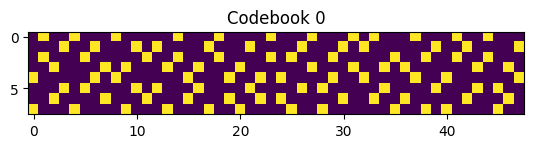

[12. 12. 12. 12. 12. 12. 12. 12.]


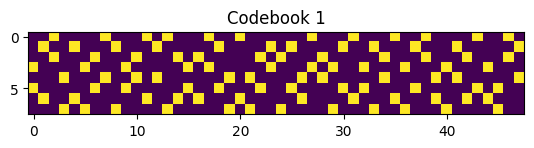

[12. 12. 12. 12. 12. 12. 12. 12.]


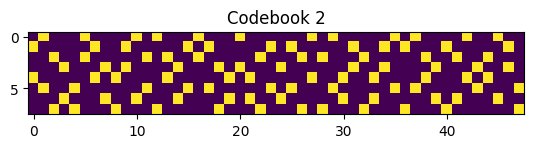

[12. 12. 12. 12. 12. 12. 12. 12.]


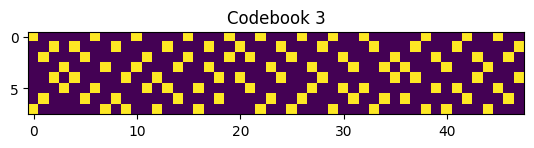

[12. 12. 12. 12. 12. 12. 12. 12.]


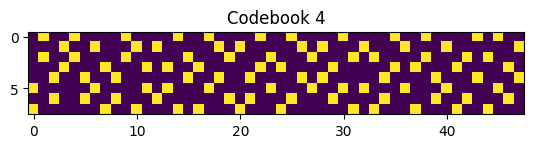

[12. 12. 12. 12. 12. 12. 12. 12.]


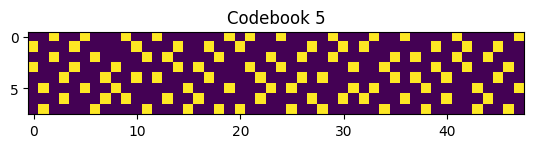

[12. 12. 12. 12. 12. 12. 12. 12.]


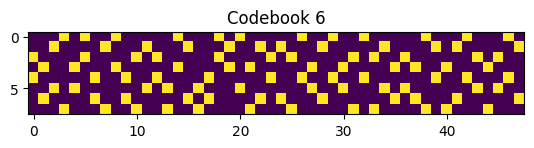

[12. 12. 12. 12. 12. 12. 12. 12.]


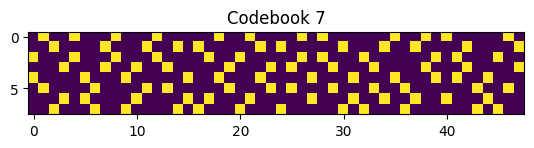

[12. 12. 12. 12. 12. 12. 12. 12.]


In [32]:
import matplotlib.pyplot as plt
for i, codebook in enumerate(controller.codebooks):
    plt.title(f'Codebook {i}')
    plt.imshow(np.array(codebook).T)
    plt.show()
    print(np.sum(codebook, axis=0))

In [ ]:
n_objs = 8
obj_idc = [f'obj_{i}' for i in range(n_objs)]
n_runs = 8
run_idc = [f'run_{i}' for i in range(n_runs)]
n_blocks = 4
block_idc = [f'block_{i}' for i in range(n_blocks)]

